# Randomized Hilbert-Schmidt Criterion From Scratch

In [17]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')

import numba
import numpy as np
from sklearn.utils import check_random_state
from kernellib.dependence import get_sample_data, HSIC, RHSIC
from kernellib.kernels import estimate_length_scale, rbf_kernel
from kernellib.kernels.kernel_approximation import RFF
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.style.use('fivethirtyeight')

my_colors = [
    '#000000',
    '#ff0000', 
    
]

cmap=LinearSegmentedColormap.from_list('mycmap', my_colors)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


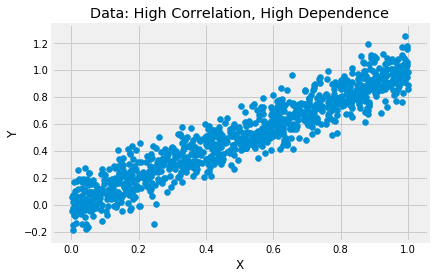

In [2]:
X, Y = get_sample_data(dataset='hh', num_points=1000, seed=1234, noise=0.1)

n_samples, d_dimensions = X.shape

fig, ax = plt.subplots()

ax.scatter(X, Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data: High Correlation, High Dependence')
plt.show()

## RHSIC Algorithm

### Step I: Compute Kernel

#### RFF Kernel

In [29]:
# Estimate Length_scale Parameters
sub_sample   = 1000
method       = 'median'
seed         = 1234
factor       = 1 / (n_samples - 1)**2
sigma_x = estimate_length_scale(
    X, 
    sub_sample=sub_sample,
    method=method,
    random_state=seed
)

sigma_y = estimate_length_scale(
    Y, 
    sub_sample=sub_sample,
    method=method,
    random_state=seed
)

print(f"\u03BB_x = {sigma_x:.4f}")
print(f"\u03BB_y = {sigma_x:.4f}")

λ_x = 0.2119
λ_y = 0.2119


In [62]:
# Number of random features
n_features = 500
random_state = 1234

rng = check_random_state(random_state)

# ======================
# Kernel Matrix: X
# ======================
# Generate n_components iid samples (Random Projection Matrix)
Wx = (1 / sigma_x) * rng.randn(d_dimensions, n_features)

# Explicitly project the features
Zx = (1 / np.sqrt(n_features)) * np.exp(1j * X @ Wx)



# ======================
# Kernel Matrix: Y
# ======================
rng = check_random_state(random_state)
# Generate n_components iid samples (Random Projection Matrix)
Wy = (1 / sigma_y) * rng.randn(d_dimensions, n_features)

# Explicitly project the features
Zy = (1 / np.sqrt(n_features)) * np.exp(1j * Y @ Wy)

### Step II: Center Kernels

In [63]:
# Remove the Mean
Zxc = Zx - np.mean(Zx, axis=0)[None, :]
Zyc = Zy - np.mean(Zy, axis=0)[None, :]

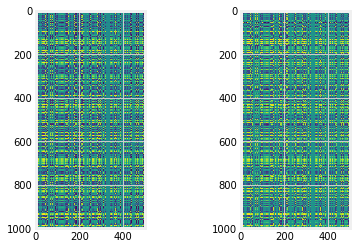

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2)

p0 = ax[0].imshow(np.real(Zxc), )
p1 = ax[1].imshow(np.real(Zyc), )

plt.show()

### RFF Kernel Approximation Class

In [79]:
rff_model = RFF(
    n_components=n_features,
    length_scale=None,
    method='median',
    center=False,
    random_state=1234
)
Zx_ = rff_model.fit_transform(X)

np.testing.assert_array_almost_equal(Zx, Zx_)

In [80]:
rff_model = RFF(
    n_components=n_features,
    length_scale=None,
    method='median',
    center=True,
    random_state=1234
)
Zxc_ = rff_model.fit_transform(X)

np.testing.assert_array_almost_equal(Zxc, Zxc_)

### Step III - Compute HSIC Value

$$RHSIC() = factor \left(\tilde{Z}_x\tilde{Z}_x^{\top} \tilde{Z}_y\tilde{Z}_y^{\top} \right)$$
$$RHSIC() = factor \left(\tilde{Z}_x^{\top}\tilde{Z}_y \tilde{Z}_y^{\top}\tilde{Z}_x \right)$$

In [81]:
Rxy = np.matrix.getH(Zxc).dot(Zyc)
rh = factor * np.real(np.einsum('ij,ji->', Rxy, np.matrix.getH(Rxy)))

In [82]:
print(rh)

0.09046440707021397


### Step I - Data & Parameters

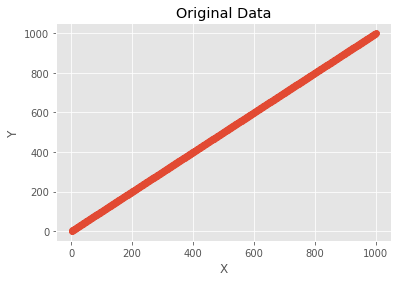

In [57]:
X = rhsic_data['x']
Y = rhsic_data['y']

n, d = X.shape
n_features = rhsic_data['D'][0][0]

fig, ax = plt.subplots()

ax.scatter(X, Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.show()

## MATLAB Calculation


In [64]:
factor = 1 / (n - 1)**2
factor_matlab = rhsic_data['factor'][0][0]

print(f"factor: {factor}")
print(f'factor (matlab): {factor_matlab}')

factor: 1.002003004005006e-06
factor (matlab): 1.002003004005006e-06


In [65]:
zx_matlab = rhsic_data['zx']
Wx_matlab = rhsic_data['Wx']
Zx_matlab = rhsic_data['Zx']
Zxc_matlab = rhsic_data['Zxc']

zy_matlab = rhsic_data['zy']
Wy_matlab = rhsic_data['Wy']
Zy_matlab = rhsic_data['Zy']
Zyc_matlab = rhsic_data['Zyc']
hsic_matlab = rhsic_data['hsic'][0][0]

print(f"MATLAB HSIC: {hsic_matlab}")


# np.testing.assert_array_almost_equal(Rxy, Rxy_matlab, decimal=1)


MATLAB HSIC: 0.1263408047134729


In [69]:
print(Zxc_matlab.shape, Zyc_matlab.shape)
print(Rxy_matlab.shape, Rxy.shape)

(1000, 100) (1000, 100)
(100, 100) (100, 100)


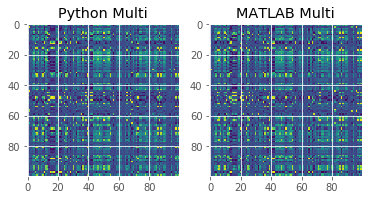

In [74]:
# Calculate RHSIC
Rxy = Zxc_matlab.T @ Zyc_matlab #Zxc_matlab.T @ Zyc_matlab
Rxy_matlab = rhsic_data['Rxy']

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(np.real(Rxy))
ax[1].imshow(np.real(Rxy_matlab))
ax[0].set_title('Python Multi')
ax[1].set_title('MATLAB Multi')
plt.show()

In [77]:
Rxy_matlab[:2, :2]

array([[-1.09601796+5.65268504j,  0.55643093-1.44291788j],
       [-0.14915046+1.90796434j,  0.47450491-1.82363041j]])

In [81]:
np.transpose(Rxy_matlab[:2, :2])

array([[-1.09601796+5.65268504j, -0.14915046+1.90796434j],
       [ 0.55643093-1.44291788j,  0.47450491-1.82363041j]])

In [83]:
    
hsic = factor * np.real(np.trace( Rxy @ Rxy.T))
hsic_matlab = factor * np.real(np.trace( Rxy_matlab @ np.matrix.getH(Rxy_matlab)))

print(f'HSIC Py (I): {hsic}')
print(f'HSIC Matlab (I): {hsic_matlab}')

HSIC Py (I): 0.007574781979556385
HSIC Matlab (I): 0.1263408047134729


In [ ]:
# Calculate RHSIC
Zxx_matlab = Zx_matlab @ Zxc_matlab.T
Zyy_matlab = Zy_matlab @ Zyc_matlab.T
hsic_matlab = (1 / (n - 1)**2) * np.real(np.trace(Zxx_matlab * Zyy_matlab))

print(f'HSIC Matlab (II): {hsic_matlab}')

### Step II - Estimate Kernel Parameters

In [31]:
# Use matlab kernel parameters
sigma_x = rhsic_data['sigmax'][0][0]
sigma_y = rhsic_data['sigmay'][0][0]

print(f'Sigma_x: {sigma_x}')
print(f'Sigma_y: {sigma_y}')

Sigma_x: 207.88939366884497
Sigma_y: 207.88939366884497


### Generate Random normal vector

$zx \sim \mathcal{N}(0, 1) \in \mathbb{R}^{DxF}$

where:
* $D$ is the number of dimensions
* $F$ is the number of features

In [39]:
# set random generator
rng = check_random_state(1234)

n, d = X.shape
n_features = rhsic_data['D'][0][0]

# generate random samples
zx = rng.randn(d, n_features)
zx_matlab = rhsic_data['zx']

print(zx.shape, zx_matlab.shape)

(1, 100) (1, 100)


### Random Features Kernel

In [42]:
Wx = (1 / sigma_x) * zx
Wx_matlab = (1 / sigma_x) * zx_matlab
